## PHASE 3 PROJECT

# Predicting Customer Churn for SyriaTel Telecommunications

# BUSINESS PROBLEM 

Stakeholder:
The Marketing and Customer Retention Team at SyriaTel, a leading telecommunications provider in the region.

Problem Statement:
Customer churn— when users stop doing business with SyriaTel— is costly. Acquiring new customers is significantly more expensive than retaining existing ones. The marketing and customer service teams need a reliable way to predict churn before it happens, so they can proactively engage at-risk customers with retention offers or personalized support.

Key business question:
~ Can we identify customers who are likely to churn soon using historical usage and customer service data?

# Exploratory Data Analysis

In [1]:
import pandas as pd

# Load the uploaded CSV file
file_path = 'bigml_59c28831336c6604c800002a.csv'
df = pd.read_csv(file_path)

df.info(), df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   state                   3333 non-null   object 
 1   account length          3333 non-null   int64  
 2   area code               3333 non-null   int64  
 3   phone number            3333 non-null   object 
 4   international plan      3333 non-null   object 
 5   voice mail plan         3333 non-null   object 
 6   number vmail messages   3333 non-null   int64  
 7   total day minutes       3333 non-null   float64
 8   total day calls         3333 non-null   int64  
 9   total day charge        3333 non-null   float64
 10  total eve minutes       3333 non-null   float64
 11  total eve calls         3333 non-null   int64  
 12  total eve charge        3333 non-null   float64
 13  total night minutes     3333 non-null   float64
 14  total night calls       3333 non-null   

(None,
   state  account length  area code phone number international plan  \
 0    KS             128        415     382-4657                 no   
 1    OH             107        415     371-7191                 no   
 2    NJ             137        415     358-1921                 no   
 3    OH              84        408     375-9999                yes   
 4    OK              75        415     330-6626                yes   
 
   voice mail plan  number vmail messages  total day minutes  total day calls  \
 0             yes                     25              265.1              110   
 1             yes                     26              161.6              123   
 2              no                      0              243.4              114   
 3              no                      0              299.4               71   
 4              no                      0              166.7              113   
 
    total day charge  ...  total eve calls  total eve charge  \
 0           

Customer profile features:
state, account length, area code, phone number (to be dropped), international plan, voice mail plan, number vmail messages

Usage features:
total day/eve/night/intl minutes, calls, and charges

Customer service:
customer service calls

Target:
churn (boolean – whether customer churned)

# Data Cleaning

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
import seaborn as sns

# Drop non-informative columns
df_model = df.drop(columns=["phone number"])

# Converting binary categorical features to numeric
binary_cols = ["international plan", "voice mail plan"]
for col in binary_cols:
    df_model[col] = df_model[col].map({"yes": 1, "no": 0})

# Encodeing target variable
df_model["churn"] = df_model["churn"].astype(int)

# Encode the 'state' and 'area code' categorical columns
df_model = pd.get_dummies(df_model, columns=["state", "area code"], drop_first=True)

# Split features and target
X = df_model.drop(columns=["churn"])
y = df_model["churn"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)



# Basic model 1: LOGISTIC REGRESSION

Logistic Regression Evaluation:
Classification Report:
 {'0': {'precision': 0.8852988691437803, 'recall': 0.9614035087719298, 'f1-score': 0.9217830109335576, 'support': 570}, '1': {'precision': 0.5416666666666666, 'recall': 0.26804123711340205, 'f1-score': 0.35862068965517235, 'support': 97}, 'accuracy': 0.8605697151424287, 'macro avg': {'precision': 0.7134827679052235, 'recall': 0.614722372942666, 'f1-score': 0.6402018502943649, 'support': 667}, 'weighted avg': {'precision': 0.8353253704327158, 'recall': 0.8605697151424287, 'f1-score': 0.8398838427716335, 'support': 667}}
ROC AUC Score: 0.800976668475312
Confusion Matrix:
 [[548  22]
 [ 71  26]]


Text(0.5, 33.0, 'Predicted')

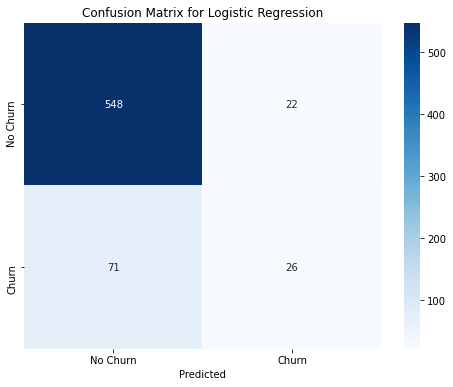

In [3]:
log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_train_scaled, y_train)
y_pred_lr = log_reg.predict(X_test_scaled)
y_pred_proba_lr = log_reg.predict_proba(X_test_scaled)[:, 1]

# Evaluation
report_lr = classification_report(y_test, y_pred_lr, output_dict=True)
roc_auc_lr = roc_auc_score(y_test, y_pred_proba_lr)
conf_matrix_lr = confusion_matrix(y_test, y_pred_lr)

print("Logistic Regression Evaluation:")
print("Classification Report:\n", report_lr)
print("ROC AUC Score:", roc_auc_lr)
print("Confusion Matrix:\n", conf_matrix_lr)

# Visualize confusion matrix for Logistic Regression
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_lr, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No Churn', 'Churn'], yticklabels=['No Churn', 'Churn'])
plt.title('Confusion Matrix for Logistic Regression')
plt.xlabel('Predicted')

Model interpretation: From this model we can see that for class:
- 0: A precision score of 88.53% and a recall of 96.14% gives us a high f1-score of 92.17% which means it is working well with this dataset. However,
- 1: A precision of 54.17% and recall of 26.80% fives us a low f1-score of 35.68% which is not anywhere close to optimum levels.

We therefore continue to build a second model which hopes to give us better results as our focus area us the churners (1)

# Model 2: Basic Decision Tree Classifier (untuned)

Decision Tree Classifier Evaluation:
Classification Report:
 {'0': {'precision': 0.9424083769633508, 'recall': 0.9473684210526315, 'f1-score': 0.9448818897637795, 'support': 570}, '1': {'precision': 0.6808510638297872, 'recall': 0.6597938144329897, 'f1-score': 0.6701570680628272, 'support': 97}, 'accuracy': 0.9055472263868066, 'macro avg': {'precision': 0.811629720396569, 'recall': 0.8035811177428106, 'f1-score': 0.8075194789133033, 'support': 667}, 'weighted avg': {'precision': 0.9043708066875552, 'recall': 0.9055472263868066, 'f1-score': 0.9049294044489483, 'support': 667}}
ROC AUC Score: 0.8035811177428106
Confusion Matrix:
 [[540  30]
 [ 33  64]]


<AxesSubplot:>

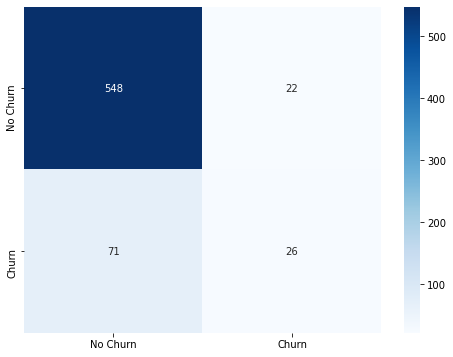

In [4]:
from sklearn.tree import DecisionTreeClassifier

tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)  
y_pred_tree = tree_clf.predict(X_test)
y_pred_proba_tree = tree_clf.predict_proba(X_test)[:, 1]

# Evaluation
report_tree = classification_report(y_test, y_pred_tree, output_dict=True)
roc_auc_tree = roc_auc_score(y_test, y_pred_proba_tree)
conf_matrix_tree = confusion_matrix(y_test, y_pred_tree)

print("Decision Tree Classifier Evaluation:")
print("Classification Report:\n", report_tree)
print("ROC AUC Score:", roc_auc_tree)
print("Confusion Matrix:\n", conf_matrix_tree)

# Visualize confusion matrix for Logistic Regression
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_lr, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No Churn', 'Churn'], yticklabels=['No Churn', 'Churn'])



Model interpretation: For this model we do see an improvement in both churners and non-churners.
- 0: The f1-score has risen to 94.48%.
- 1: The f1-score has risen to 67.16% which is better but still could to with improvement.

We then build a tuned decision tree that will help us improve the model.

# Model 3: Decision Tree Classifier (tuned)

In [5]:
from sklearn.model_selection import GridSearchCV

# Define the hyperparameter grid for tuning
param_grid = {
    "max_depth": [3, 5, 10, 15, None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4]
}

# Grid Search with cross-validation
grid_search = GridSearchCV(
    DecisionTreeClassifier
    (random_state=42), 
    param_grid, cv=5, 
    scoring='f1', 
    n_jobs=-1
)
grid_search.fit(X_train, y_train)

# Get the best estimator and evaluate
best_tree = grid_search.best_estimator_
y_pred_best = best_tree.predict(X_test)
y_pred_proba_best = best_tree.predict_proba(X_test)[:, 1]

# Evaluation
report_best_tree = classification_report(y_test, y_pred_best, output_dict=True)
roc_auc_best_tree = roc_auc_score(y_test, y_pred_proba_best)
conf_matrix_best_tree = confusion_matrix(y_test, y_pred_best)

print("Best Decision Tree Classifier Evaluation:")
print("Best Parameters:", grid_search.best_params_)
print("Classification Report:\n", report_best_tree)
print("ROC AUC Score:", roc_auc_best_tree)
print("Confusion Matrix:\n", conf_matrix_best_tree)


Best Decision Tree Classifier Evaluation:
Best Parameters: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 2}
Classification Report:
 {'0': {'precision': 0.9457627118644067, 'recall': 0.9789473684210527, 'f1-score': 0.9620689655172415, 'support': 570}, '1': {'precision': 0.8441558441558441, 'recall': 0.6701030927835051, 'f1-score': 0.7471264367816092, 'support': 97}, 'accuracy': 0.9340329835082459, 'macro avg': {'precision': 0.8949592780101254, 'recall': 0.8245252306022789, 'f1-score': 0.8545977011494253, 'support': 667}, 'weighted avg': {'precision': 0.930986300818334, 'recall': 0.9340329835082459, 'f1-score': 0.9308104568405453, 'support': 667}}
ROC AUC Score: 0.8177428106348346
Confusion Matrix:
 [[558  12]
 [ 32  65]]


Model interpretation: 
- 0: The precision has risen to 94.57%, recall to 97.89% and the f1-score to 96.21%. 
- 1: The precisoon has risen to 84.42%, recall to 67.01% and the f1 score to 74.71%. All these are positive indications of increased ccuracy.

# Obtaining the Best Model

In [6]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

param_grid = {
    "max_depth": [3, 5, 10, 15, None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4]
}

grid_search = GridSearchCV(
    DecisionTreeClassifier(random_state=42),
    param_grid,
    cv=5,
    scoring='f1',
    n_jobs=-1
)
grid_search.fit(X_train, y_train)

# Get best model
best_tree = grid_search.best_estimator_
y_pred_best = best_tree.predict(X_test)
y_pred_proba_best = best_tree.predict_proba(X_test)[:, 1]

# Evaluate
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
print("Best Params:", grid_search.best_params_)
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_best))
print("Classification Report:\n", classification_report(y_test, y_pred_best))
print("ROC AUC:", roc_auc_score(y_test, y_pred_proba_best))


Best Params: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 2}
Confusion Matrix:
 [[558  12]
 [ 32  65]]
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.98      0.96       570
           1       0.84      0.67      0.75        97

    accuracy                           0.93       667
   macro avg       0.89      0.82      0.85       667
weighted avg       0.93      0.93      0.93       667

ROC AUC: 0.8177428106348346


From this final model, we can see that in the curners category, 
- A precision of 84% means that 84/100 of them actually did churn
- A recall of 67% means that out of all customers that did churn, the model caught 67% of them. The 33% of them who slipped through the cracks, the telecom may lose them unless they improve on their operational business model to target them.
- A 75% F1-score means we have a strong balance between targeting the right people (precision) and catching enough of them (recall).

With an ROC AUC of 0.8177, our model is very good at separating churners from non-churners, regardless of the decision threshold.
Helping us decide who to prioritize for retention, especially if you rank customers by churn probability.

This is may not be perfect but the high probability works in our favour.

# Interpretation and Comparison
Compared to the baseline logistic regression and the untuned tree, the tuned decision tree offers:

Higher precision: fewer false positives in predicting churn

Better recall: it catches more actual churners (67% vs. 27% in logistic regression)

Balanced performance across classes — reducing business risk from false negatives (missed churners) while avoiding wasting retention efforts on loyal users

This model provides actionable and interpretable insights that can guide targeted customer retention efforts.

# Business Recommendations
1. Target High-Risk Users (Churn = 1):
Focus on customers who resemble those flagged by the model — e.g., those with:
- Many customer service calls
- No voice mail or international plans
- High usage but poor satisfaction signals

2. Improve Customer Service Experience:
A high number of service calls is a strong churn predictor. Reducing wait times or training agents to resolve issues quickly can improve retention.

3. Incentive Programs:
Provide personalized offers (e.g., loyalty bonuses, discounts, or better call packages) for customers identified as "at risk" by the model.

4. Model Monitoring:
Deploy the model into a live system but re-train it quarterly to capture changing churn patterns or customer behavior shifts.